In [ ]:
%%capture
!pip install causal-conv1d>=1.1.0 mamba-ssm pytorch-minimize psutil gputil

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from numpy import genfromtxt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import psutil
import GPUtil
from google.colab import drive
from mamba_ssm import Mamba

In [ ]:
# Torch device configuration
device = (
    "cuda" if torch.cuda.is_available() else "mps"
    if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")
if torch.cuda.is_available():
    print(f"Current GPU device: {torch.cuda.get_device_name(device)}")

Using cuda device
Current GPU device: Tesla T4


## Importing Data

In [ ]:
# This will prompt you to click on a link and generate an authorization code.
drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/AI/CGD_research/light-har'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load Data
x = genfromtxt(project_path+'/data/WISDM_x.csv', delimiter=',')
y_df = pd.read_csv(project_path+'/data/WISDM_y.csv')
y = y_df.values.flatten()  # Flatten if y is 2D

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Function to create time series dataset
def create_series(x, y, timestep, overlap):
    slide_step = int(timestep * (1 - overlap))
    data_num = int((len(x) / slide_step) - 1)
    dataset = np.ndarray(shape=(data_num, timestep, x.shape[1]))
    labels = []

    for i in range(data_num):
        labels.append(y[slide_step * (i + 1) - 1])
        for j in range(timestep):
            dataset[i, j, :] = x[slide_step * i + j, :]

    return dataset, np.array(labels)

# Create time series
timestep = 16  # Replace with your value
overlap = 0.5  # Replace with your value
X_series, y_series = create_series(x, y_encoded, timestep, overlap)

In [ ]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_series, y_series, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(X_train, dtype=torch.float32)
x_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print(x_train_tensor.shape)

torch.Size([104856, 16, 3])


In [ ]:
# Create a DataLoader
batch_size = 32
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Create a test Dataloader
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

## Importing the model

In [ ]:
class TimeSeriesMamba(nn.Module):
    def __init__(self, sequence_length, num_features, head_size, n_heads, ff_dim, n_trans_blocks, mlp_units, drop=0.0, mlp_drop=0.0):
        super(TimeSeriesMamba, self).__init__()

        # Encoder module
        self.encoders = nn.ModuleList([
            Mamba(
                d_model=num_features,
                d_state=16,
                d_conv=4,
                expand=2,
        ) for _ in range(n_trans_blocks)])

        # Global average pooling
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)

        # MLP layers
        mlp_layers = []
        current_dim = num_features
        for dim in mlp_units:
            mlp_layers.extend([
                nn.Linear(current_dim, dim),
                nn.ReLU(),
                nn.Dropout(mlp_drop) if mlp_drop > 0.0 else nn.Identity(),  # Apply dropout conditionally
            ])
            current_dim = dim

        self.mlp = nn.Sequential(*mlp_layers)
        self.final_layer = nn.Linear(mlp_units[-1], 6)

    def forward(self, input_data):
        # Encoder
        for encoder in self.encoders:
            encoded_data = encoder(input_data)

        # Global average pooling
        encoded_data = encoded_data.permute(0, 2, 1)
        global_avg_pooled = self.global_avg_pooling(encoded_data)
        flattened = torch.flatten(global_avg_pooled, 1)

        # MLP
        mlp_output = self.mlp(flattened)

        # Final layer
        output = self.final_layer(mlp_output)
        return output

# Model instantiation
model = TimeSeriesMamba(
    sequence_length=16,
    num_features=3,
    head_size=3,
    n_heads=1,
    ff_dim=64,
    n_trans_blocks=4,
    mlp_units=[128, 64],
    drop=0.1,
    mlp_drop=0.1
)

# Move model to device
model.to(device)


TimeSeriesMamba(
  (encoders): ModuleList(
    (0-3): 4 x Mamba(
      (in_proj): Linear(in_features=3, out_features=12, bias=False)
      (conv1d): Conv1d(6, 6, kernel_size=(4,), stride=(1,), padding=(3,), groups=6)
      (act): SiLU()
      (x_proj): Linear(in_features=6, out_features=33, bias=False)
      (dt_proj): Linear(in_features=1, out_features=6, bias=True)
      (out_proj): Linear(in_features=6, out_features=3, bias=False)
    )
  )
  (global_avg_pooling): AdaptiveAvgPool1d(output_size=1)
  (mlp): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
  )
  (final_layer): Linear(in_features=64, out_features=6, bias=True)
)

In [ ]:
# Validate the model given the dataloader and return loss and accuracy
def validate(model, dataloader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    running_loss = 0.0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            inputs, labels = X_batch.to(device), y_batch.to(device)
            output = model(inputs)
            loss = criterion(output, labels)
            running_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    avg_loss = running_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predicted_labels) * 100

    return avg_loss, accuracy

# Plot training history and save figures
def plot_metrics(num_epochs, train_losses, val_losses, val_accuracies, save_path=None):
    epochs = range(1, num_epochs + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(epochs, train_losses, label='Training Loss', marker='o', color='blue')
    ax1.plot(epochs, val_losses, label='Validation Loss', marker='o', color='red')
    ax1.set_title('Training and Validation Losses')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o', color='green')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()


## Untrained Accuracy

In [ ]:
model.to(device)
loss, accuracy = validate(model, test_loader, device)
print(f"Untrained model accuracy = {accuracy:.2f} %")

Untrained model accuracy = 11.17 %


## Training

In [ ]:
import torch
from torch.nn import CrossEntropyLoss

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters())

loss_fn = CrossEntropyLoss()

num_epochs = 300
best_val_accuracy = 0.0  # Variable to track the best validation accuracy
best_model_state = None  # Variable to store the state of the best model

train_losses = []  # List to store training losses
val_losses = []    # List to store validation losses
val_accuracies = []  # List to store validation accuracies

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        # Move inputs and labels to the selected device
        inputs, labels = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation loss calculation
    val_loss, val_acc = validate(model, test_loader, device)
    val_accuracies.append(val_acc)
    val_losses.append(val_loss)

    # Save the model if the current validation accuracy is better than the best
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model_state = model.state_dict()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

print('Finished Training')
model.load_state_dict(best_model_state)
print('Best model state restored')

# Save the best model
model_path = project_path+'/models/mamba_base.pt'
torch.save(model.state_dict(), model_path)
print(f'Best model saved at {model_path}')

Epoch [1/300], Train Loss: 0.7099, Val Accuracy: 78.40%
Epoch [2/300], Train Loss: 0.5824, Val Accuracy: 80.30%
Epoch [3/300], Train Loss: 0.5503, Val Accuracy: 81.02%
Epoch [4/300], Train Loss: 0.5273, Val Accuracy: 81.77%
Epoch [5/300], Train Loss: 0.5075, Val Accuracy: 82.24%
Epoch [6/300], Train Loss: 0.4922, Val Accuracy: 82.70%
Epoch [7/300], Train Loss: 0.4795, Val Accuracy: 83.16%
Epoch [8/300], Train Loss: 0.4695, Val Accuracy: 83.31%
Epoch [9/300], Train Loss: 0.4632, Val Accuracy: 83.59%
Epoch [10/300], Train Loss: 0.4573, Val Accuracy: 83.61%
Epoch [11/300], Train Loss: 0.4522, Val Accuracy: 83.79%
Epoch [12/300], Train Loss: 0.4492, Val Accuracy: 84.10%
Epoch [13/300], Train Loss: 0.4459, Val Accuracy: 84.26%
Epoch [14/300], Train Loss: 0.4434, Val Accuracy: 84.35%
Epoch [15/300], Train Loss: 0.4406, Val Accuracy: 84.22%
Epoch [16/300], Train Loss: 0.4392, Val Accuracy: 84.08%
Epoch [17/300], Train Loss: 0.4358, Val Accuracy: 84.47%
Epoch [18/300], Train Loss: 0.4353, Val 

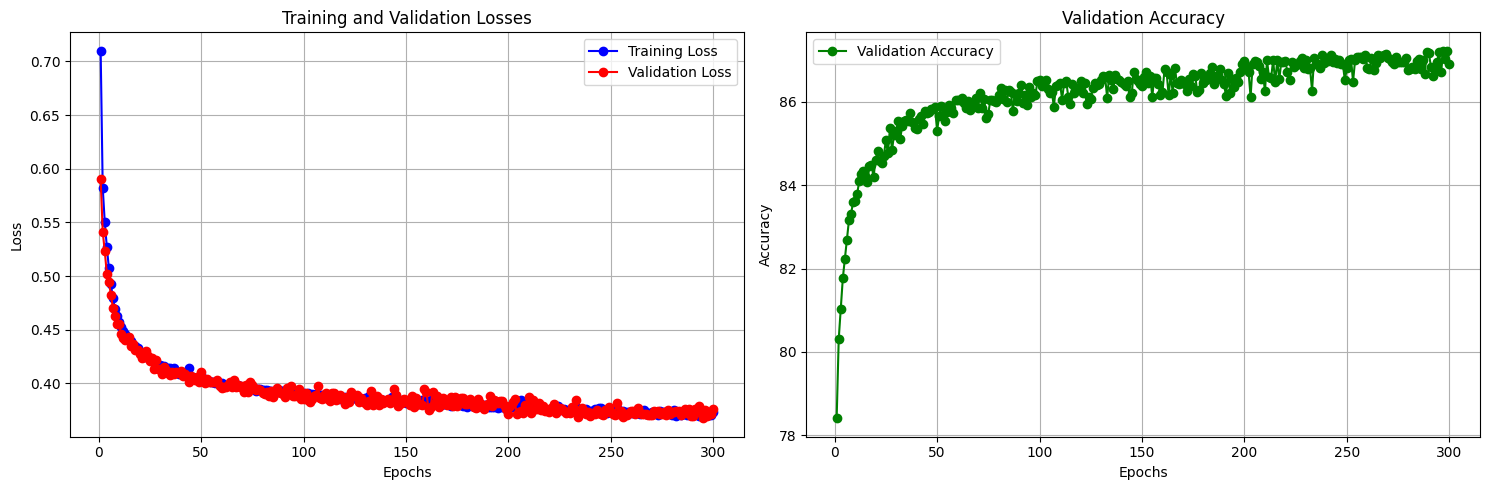

In [ ]:
# Plot and save figures
plot_metrics(num_epochs,
             train_losses,
             val_losses,
             val_accuracies,
             save_path=project_path+'/models/mamba_base.png')

## Conjugate Gradient method

In [ ]:
# Model instantiation
model = TimeSeriesMamba(
    sequence_length=16,
    num_features=3,
    head_size=3,
    n_heads=1,
    ff_dim=64,
    n_trans_blocks=4,
    mlp_units=[128, 64],
    drop=0.1,
    mlp_drop=0.1
)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TimeSeriesMamba(
  (encoders): ModuleList(
    (0-3): 4 x Mamba(
      (in_proj): Linear(in_features=3, out_features=12, bias=False)
      (conv1d): Conv1d(6, 6, kernel_size=(4,), stride=(1,), padding=(3,), groups=6)
      (act): SiLU()
      (x_proj): Linear(in_features=6, out_features=33, bias=False)
      (dt_proj): Linear(in_features=1, out_features=6, bias=True)
      (out_proj): Linear(in_features=6, out_features=3, bias=False)
    )
  )
  (global_avg_pooling): AdaptiveAvgPool1d(output_size=1)
  (mlp): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
  )
  (final_layer): Linear(in_features=64, out_features=6, bias=True)
)

In [ ]:
# Training setup
training_percentage = 1.0  # Set the desired percentage of training samples

# Calculate the number of training samples
n_total_samples = x_train_tensor.shape[0]
n_training_data = int(training_percentage * n_total_samples)

# Create a subset of the training data
subset_indices = torch.randperm(n_total_samples)[:n_training_data]
x_train_subset = x_train_tensor[subset_indices]
y_train_subset = y_train_tensor[subset_indices]

# Create a DataLoader for the subset
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=n_training_data, shuffle=False)

# Create a test Dataloader
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
import torch
from torchmin import Minimizer
from torch.nn import CrossEntropyLoss

# Define the optimizer and loss function
optimizer = Minimizer(model.parameters(),
                      method='cg',
                      tol=1e-5,
                      max_iter=2,
                      disp=0)

loss_fn = CrossEntropyLoss()
num_epochs = 300
best_val_accuracy = 0.0
best_model_state = None

train_losses = []  # List to store training losses
val_losses = []    # List to store validation losses
val_accuracies = []  # List to store validation accuracies

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        # Move inputs and labels to the selected device
        inputs, labels = X_batch.to(device), y_batch.to(device)

        def closure():
            optimizer.zero_grad()
            output = model(inputs)
            loss = loss_fn(output, labels)
            # loss.backward()  <-- do not call backward!
            return loss

        loss = optimizer.step(closure)
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation loss calculation
    val_loss, val_acc = validate(model, test_loader, device)
    val_accuracies.append(val_acc)
    val_losses.append(val_loss)

    # Save the model if the current validation accuracy is better than the best
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model_state = model.state_dict()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

print('Finished Training')
model.load_state_dict(best_model_state)
print('Best model state restored')

# Save the best model
model_path = project_path+'/models/mamba_cg_base.pt'
torch.save(model.state_dict(), model_path)
print(f'Best model saved at {model_path}')

Epoch [1/300], Train Loss: 0.3736, Val Accuracy: 57.77%
Epoch [2/300], Train Loss: 0.3736, Val Accuracy: 60.60%
Epoch [3/300], Train Loss: 0.3736, Val Accuracy: 58.88%
Epoch [4/300], Train Loss: 0.3736, Val Accuracy: 63.74%
Epoch [5/300], Train Loss: 0.3736, Val Accuracy: 63.69%
Epoch [6/300], Train Loss: 0.3736, Val Accuracy: 64.19%
Epoch [7/300], Train Loss: 0.3736, Val Accuracy: 64.33%
Epoch [8/300], Train Loss: 0.3736, Val Accuracy: 65.75%
Epoch [9/300], Train Loss: 0.3736, Val Accuracy: 66.15%
Epoch [10/300], Train Loss: 0.3736, Val Accuracy: 66.62%
Epoch [11/300], Train Loss: 0.3736, Val Accuracy: 67.11%
Epoch [12/300], Train Loss: 0.3736, Val Accuracy: 68.09%
Epoch [13/300], Train Loss: 0.3736, Val Accuracy: 68.08%
Epoch [14/300], Train Loss: 0.3736, Val Accuracy: 68.91%
Epoch [15/300], Train Loss: 0.3736, Val Accuracy: 69.19%
Epoch [16/300], Train Loss: 0.3736, Val Accuracy: 70.09%
Epoch [17/300], Train Loss: 0.3736, Val Accuracy: 70.41%
Epoch [18/300], Train Loss: 0.3736, Val 

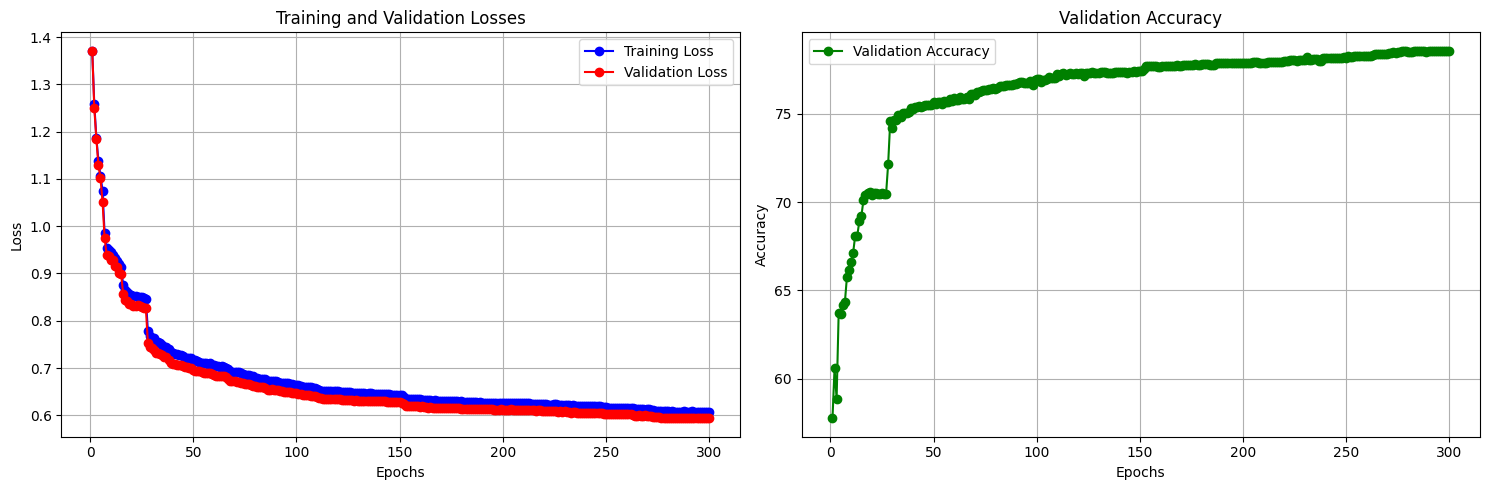

In [ ]:
# Plot and save figures
plot_metrics(num_epochs,
             train_losses,
             val_losses,
             val_accuracies,
             save_path=project_path+'/models/mamba_cg_base.png')